# Imports

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm, trange


from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Data Loading

In [2]:
train_image_dir = "../input/datathonindoml-2022/train/train"
valid_image_dir = "../input/datathonindoml-2022/validation/validation"

In [3]:
train_image_file_paths = [ os.path.join(train_image_dir, x) for x in os.listdir(train_image_dir)]
valid_image_file_paths = [ os.path.join(valid_image_dir, x) for x in os.listdir(valid_image_dir)]

In [4]:
xlabels = pd.read_csv('../input/datathonindoml-2022/train_labels.csv')
xlabels.head(5)

,id,label
0,0,1
1,1,13
2,2,13
3,3,14
4,4,6


In [5]:
def find_file_id(path):
    file_id = int((path.split("/")[-1]).split(".")[0])
    return file_id

def find_image_label(path):
    file_id = find_file_id(path)
    return (xlabels[xlabels.id==file_id]).values[0][1]


print("Path:", train_image_file_paths[0])
print("File ID:", find_file_id(train_image_file_paths[0]))
print("Label:", find_image_label(train_image_file_paths[0]))

Path: ../input/datathonindoml-2022/train/train/8394.tif
File ID: 8394
Label: 10


In [6]:
y_labels = [find_image_label(x) for x in train_image_file_paths]
y_labels[:10]

[10, 10, 4, 8, 1, 9, 11, 15, 3, 7]

<AxesSubplot:>

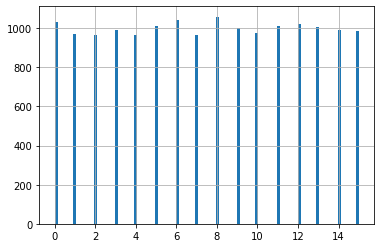

In [7]:
xlabels.label.hist(bins=100)

../input/datathonindoml-2022/train/train/14571.tif (1000, 754) 15


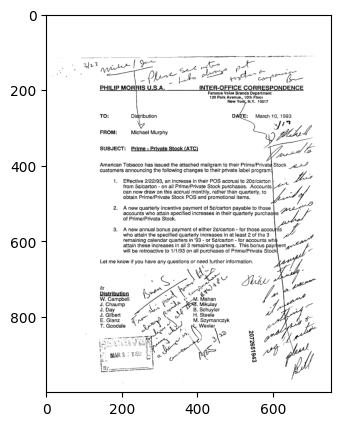

In [8]:
figure(figsize=(5, 5), dpi=100)
idx = 98
sample = train_image_file_paths[idx]
sample_img = io.imread(sample)
print(sample, sample_img.shape, y_labels[idx])
plt.imshow(sample_img, cmap='gray')

{10: 0, 4: 2, 8: 3, 1: 4, 9: 5, 11: 6, 15: 7, 3: 8, 7: 9, 6: 10, 12: 11, 13: 12, 5: 13, 0: 18, 2: 27, 14: 49}
16


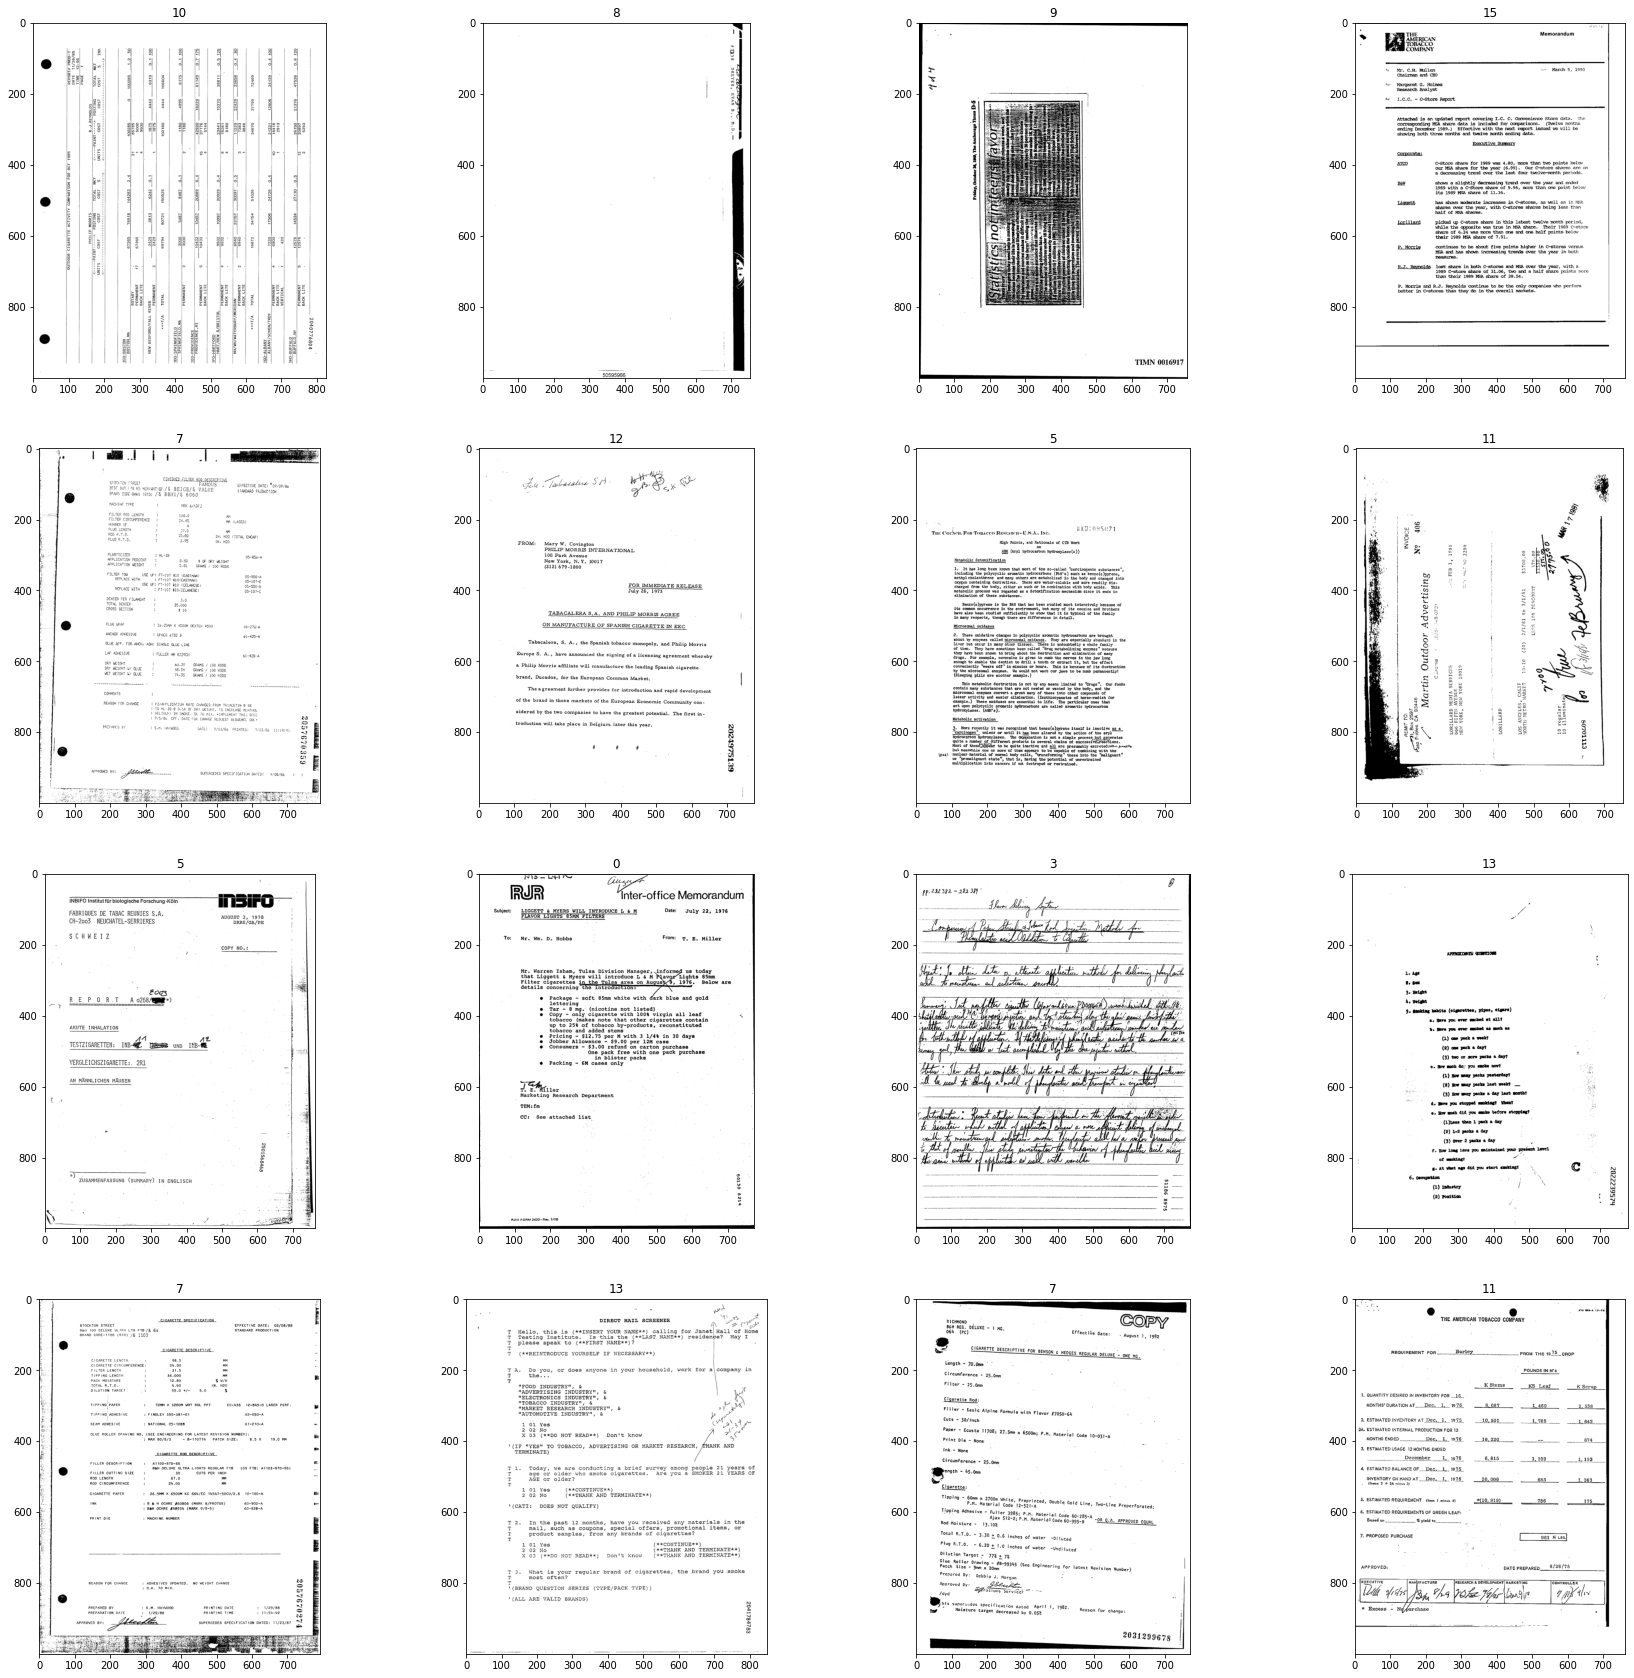

In [9]:
a={}
for idx, label in enumerate(y_labels):
    if label not in a:
        a[label] = idx
print(a)
print(len(a))

fig, axis = plt.subplots(4, 4)
fig.set_figheight(30)
fig.set_figwidth(30)

a = list(a.values())

test_set = []
test_set_pred = []

for i in range(4):
    for j in range(4):
        idx = a[i*4 + j]
        lbl = y_labels[idx]
        sample = train_image_file_paths[idx]
        test_set.append(sample)
        test_set_pred.append(lbl)
        sample_img = io.imread(sample)/255.0
        axis[i, j].imshow(sample_img, cmap='gray')
        axis[i, j].set_title(lbl)
        del train_image_file_paths[idx]
        del y_labels[idx]

In [10]:
len(train_image_file_paths), xlabels.shape[0]

(15984, 16000)

# Data Generator

In [11]:
def prep_train_feature_data(paths, dim=(100,100)):
    total=len(paths)
    x = np.zeros((total, dim[0], dim[1], 3), dtype='float')
    for i,path in (enumerate((paths))):
        img = io.imread(path)/255.0
        img =  resize(img, (dim[0], dim[1]))
        img = img.reshape((dim[0], dim[1]))
        x[i,:,:,0] = img
        x[i,:,:,1] = img
        x[i,:,:,2] = img
    return x

In [12]:
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, paths, batch_size=32, dim=(300, 300)):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.paths = paths

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.paths)//self.batch_size

    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        index_start = idx*self.batch_size
        index_end = (idx+1)*self.batch_size

        sub_paths = self.paths[index_start:index_end]
        
        X = prep_train_feature_data(sub_paths, self.dim)
        y = [find_image_label(path) for path in sub_paths]

        return X, np.array(y)

In [13]:
n_classes=len(set(y_labels))
image_size = (229, 229)

In [14]:
validation_data = prep_train_feature_data(test_set, image_size)
validation_preds = np.array(test_set_pred)
validation = (validation_data, validation_preds)

# Neural Network

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [29]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_process
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input as vgg_process

input_shape = image_size
input_shape = input_shape + (3,)
inputs = keras.Input(input_shape)

image_augment_input = layers.RandomFlip()(inputs) 
image_augment_input = layers.RandomRotation(factor=1.0)(image_augment_input)

In [30]:
# create the first base pre-trained model
# model 1 output -  (None, 16, 16, 1280)  
base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model1.trainable = False

x1 = base_model1(image_augment_input, training=False)
x1 = layers.Conv2D(512, 2, activation='relu')(x1)

In [31]:
# create the secpmd base pre-trained model
# model 2 output - (None, 16, 16, 1280)  
base_model2 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
base_model2.trainable = False

x2 = base_model2(image_augment_input, training=False)

In [32]:
x = layers.Average()([x1, x2])

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Regularize with dropout
outputs = keras.layers.Dense(n_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
random_flip_1 (RandomFlip)      (None, 229, 229, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
random_rotation_1 (RandomRotati (None, 229, 229, 3)  0           random_flip_1[0][0]              
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 8, 8, 2048)   23587712    random_rotation_1[0][0]          
____________________________________________________________________________________________

In [33]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [34]:
train_generator = DataGenerator(train_image_file_paths, batch_size=128, dim=image_size)

In [ ]:
epochs = 10
history = model.fit(
    train_generator, epochs=epochs, validation_data = validation
)

Epoch 1/10
 87/124 [====================>.........] - ETA: 1:45 - loss: 3.1126 - accuracy: 0.2680

In [ ]:
base_model1.trainable = True
base_model2.trainable = True
model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
epochs = 4
train_generator = DataGenerator(train_image_file_paths, batch_size=64, dim=image_size)
history = model.fit(
    train_generator, epochs=epochs, validation_data = validation
)

# Evaluation

In [ ]:
y_test_res = model.predict(validation_data)
for i in range(validation_data.shape[0]):
    idx = np.argmax(y_test_res[i])
    print(f"Actual: {validation_preds[i]} Predicted: {idx}")

In [ ]:
def pred_results(model, paths, img_size):
    y_pred = []
    for path in tqdm(paths):
        test_data = prep_train_feature_data([path], img_size)
        res = model.predict(test_data)
        idx = np.argmax(res[0])
        y_pred.append(idx)
    return y_pred

In [ ]:
y_pred_formatted = pred_results(model, valid_image_file_paths, image_size)

In [ ]:
ids = [find_file_id(path) for path in valid_image_file_paths]

In [ ]:
eval_df = pd.DataFrame()
eval_df['id'] = ids
eval_df['label'] = y_pred_formatted

In [ ]:
eval_df.to_csv('submission12.csv', index=False)

In [ ]:
eval_df